# How to use Frame2D


### Step 1: Import dependencies
Note: You need to add path to the frame2d.py -file

In [1]:
import sys
# path to frame2d.py file
sys.path.append("S:\91202_METKU\Kristo\Python\src")
# this path has the file tables_and_tuples.py which is used by FrameMember -class
sys.path.append('S:\91202_METKU\Kristo\Python\src\End-plate')

from frame2d import Frame2D, SteelBeam, SteelColumn, FixedSupport, YHingedSupport, PointLoad, LineLoad

### Step 2: Create frame 'envelope'

In [2]:
frame = Frame2D()

### Step 3: Create members

In [3]:
# Coordinates [[x0, y0], [x1, y1]]
coords1 = [[0,0], [0,2]]
coords2 = [[1,0], [1,1]]
coords3 = [[0,1], [1,1]]

col1 = SteelColumn(coords1)
col2 = SteelColumn(coords2)
beam1 = SteelBeam(coords3)

### Step 4: Add members to the frame

In [4]:
frame.add(col1)
frame.add(col2)
frame.add(beam1)

### Step 5: Add supports

In [5]:
supp_coord1 = [0,0]
supp_coord2 = [1,0]

frame.add(YHingedSupport(supp_coord1))
frame.add(FixedSupport(supp_coord2))

### Step 6: Add loads

In [6]:
# PointLoad(coordinate, [Fx, Fy, Mz])
load1 = PointLoad([0,2], [100,0,0])
# LineLoad(member, [q0, q1], direction)
load2 = LineLoad(beam1, [-100, -100], 'y')

frame.add(load1)
frame.add(load2)

### Step 7: Generate and plot the frame
Frame has to be always generated


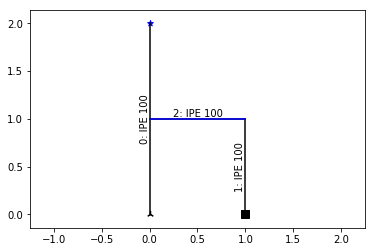

In [7]:
frame.generate()
# Optional parameters: plot(print_text=True, show=True, loads=True)
frame.plot()

### Step 8: Calculate results and plot bending moment diagram

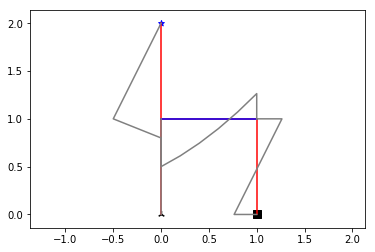

In [8]:
frame.calculate()
frame.bmd(5)

### Step 9: Design members

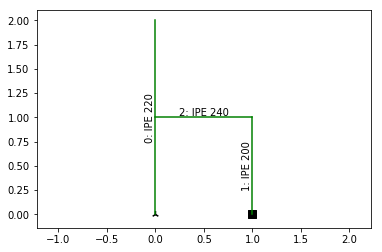

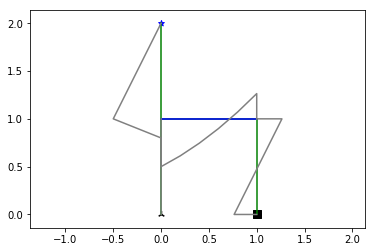

IPE 220
IPE 200
IPE 240


105.45794896874331

In [9]:
frame.design_members()
frame.plot(loads=False)
frame.bmd(5)
for member in frame.members.values():
    print(member.profile)
frame.weight

## Optimization example 1, simple frame
In this example the goal is to minimize a simple portal frame's weight by finding the optimal profile height's for the frame's members.
Optimization variables are members' heights.


### Step 1: Create frame

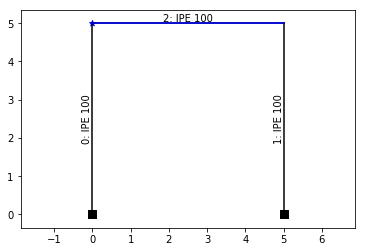

In [10]:
# Simple: [storeys, bays, storey height, bay length]
frame = Frame2D(simple=[1,1,5,5], supports='fixed', num_elements=3)

# Loads
frame.add(PointLoad([0,5], [50, 0, 0]))
frame.add(LineLoad(frame.members[2], [-50, -50], 'y'))
# Generate and plot frame
frame.generate()
frame.plot()

### Step 2: Define cost function

In [11]:
def cost_f(args):
    """
    Cost function used in optimization
    :param args: array of float, list of optimization variable values
    :return costf_value: float, frame's weight
    """
    costf_value = 0
    # Iterate through every member and change their height's
    for i, member in enumerate(frame.members.values()):
        member.h = args[i]
        costf_value += member.weight
    
    return costf_value

### Step 3: Define constraint function

In [12]:
import numpy as np
def const_f(args):
    """
    Optimization constraints
    :param args: array of float, list of optimization variable values
    :return constf_values: array of float, frame's members' stress indices
    """
    # Iterate through every member and change their height's
    for i, member in enumerate(frame.members.values()):
        member.h = args[i]
    frame.calculate()
    # Constraint values need to be <= 0
    # Stress indices must be less than 1
    stress_indices = np.asarray(frame.r)
    constf_values = 1 - stress_indices
    return constf_values

### Step 4: Create optimization function

Remember to import optimization algorithm

In [13]:
# Import particle swarm optimization algorithm
from pso import pso
def optimize(frame, lb=[80], ub=[500], maxiter=10, swarmsize=50,
             omega=2.0, phip=0.5, phig=0.5, debug=True):
    
    lb = lb * len(frame.members)
    ub = ub * len(frame.members)
    
    xopt, fopt = pso(cost_f, # Cost function
                     lb, # Lower boundary
                     ub, # Upper boundary
                     swarmsize=swarmsize, # Swarmsize
                     maxiter=maxiter, # Maximum iteration rounds
                     f_ieqcons=const_f, # Constraint function
                     debug=debug,
                     omega=omega,
                     phip=phip,
                     phig=phig)
    for i, member in enumerate(frame.members.values()):
        member.h = xopt[i]    
    frame.calculate()

### Optimization parameters


In [14]:
swarmsize = 200
maxiter = 20
lb = [80]
ub = [500]
omega = 2.0
phip = 0.5
phig = 0.5
debug = True
kwargs = {'swarmsize':swarmsize, 'maxiter':maxiter, 'lb':lb, 'ub':ub,
          'omega':omega, 'phip':phip, 'phig':phig, 'debug':debug}

Single constraint function given in f_ieqcons
Best after iteration 1: [149.73153311 284.63824218 276.57774624] 425.38493669289807
Best after iteration 2: [149.73153311 284.63824218 276.57774624] 425.38493669289807
Best after iteration 3: [149.73153311 284.63824218 276.57774624] 425.38493669289807
Best after iteration 4: [149.73153311 284.63824218 276.57774624] 425.38493669289807
Best after iteration 5: [149.73153311 284.63824218 276.57774624] 425.38493669289807
Best after iteration 6: [149.73153311 284.63824218 276.57774624] 425.38493669289807
Best after iteration 7: [149.73153311 284.63824218 276.57774624] 425.38493669289807
Best after iteration 8: [149.73153311 284.63824218 276.57774624] 425.38493669289807
Best after iteration 9: [149.73153311 284.63824218 276.57774624] 425.38493669289807
Best after iteration 10: [149.73153311 284.63824218 276.57774624] 425.38493669289807
Best after iteration 11: [149.73153311 284.63824218 276.57774624] 425.38493669289807
Best after iteration 12: [14

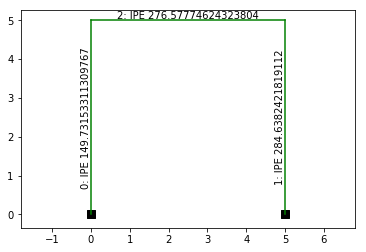

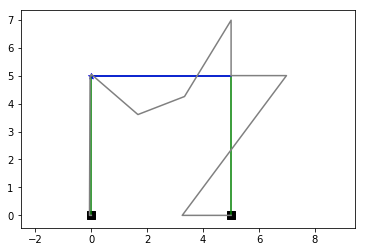

In [15]:
optimize(frame, **kwargs)
frame.plot(loads=False)
frame.bmd(15)

## Optimization example 2, custom frame

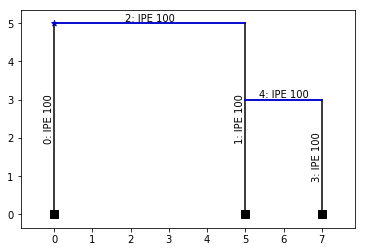

In [16]:
custom_frame = Frame2D(simple=[1,1,5,5], supports='fixed', num_elements=3)

col1 = SteelColumn([[7,0], [7,3]])
beam1 = SteelBeam([[5,3], [7,3]])

custom_frame.add(col1)
custom_frame.add(beam1)

custom_frame.add(FixedSupport([7,0]))
custom_frame.add(LineLoad(beam1, [-30, -30], 'y'))
custom_frame.add(PointLoad([0,5], [50, 0, 0]))
custom_frame.add(LineLoad(custom_frame.members[2], [-80, -80], 'y'))

custom_frame.generate()
custom_frame.plot()

Single constraint function given in f_ieqcons
Best after iteration 1: [ 90.06834946 324.2118338  337.42614595 281.85607113 148.62722561] 495.8710966823779
Best after iteration 2: [ 90.06834946 324.2118338  337.42614595 281.85607113 148.62722561] 495.8710966823779
Best after iteration 3: [ 90.06834946 324.2118338  337.42614595 281.85607113 148.62722561] 495.8710966823779
Best after iteration 4: [ 90.06834946 324.2118338  337.42614595 281.85607113 148.62722561] 495.8710966823779
Best after iteration 5: [ 90.06834946 324.2118338  337.42614595 281.85607113 148.62722561] 495.8710966823779
Best after iteration 6: [ 90.06834946 324.2118338  337.42614595 281.85607113 148.62722561] 495.8710966823779
Best after iteration 7: [ 90.06834946 324.2118338  337.42614595 281.85607113 148.62722561] 495.8710966823779
Best after iteration 8: [ 90.06834946 324.2118338  337.42614595 281.85607113 148.62722561] 495.8710966823779
Best after iteration 9: [ 90.06834946 324.2118338  337.42614595 281.85607113 148.6

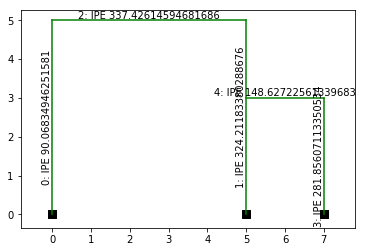

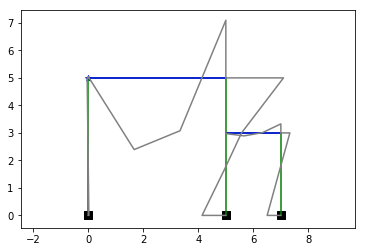

In [17]:
optimize(custom_frame, **kwargs)
custom_frame.plot(loads=False)
custom_frame.bmd(15)